<a href="https://colab.research.google.com/github/Arvinth-s/MIMO/blob/main/mimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OM NAMO NARAYANA

In [2]:
from scipy import io
import os

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
target_dir = '/content/drive/MyDrive/Antenna/project/'
os.listdir(target_dir)

['rxSig11-sample.mat',
 'rxSig21-sample.mat',
 'rxSig12-sample.mat',
 'target-sample.mat']

In [ ]:
rxSig11 = io.loadmat(target_dir + 'rxSig11-sample.mat')
rxSig11 = rxSig11['rxSig11']
rxSig12 = io.loadmat(target_dir + 'rxSig12-sample.mat')
rxSig12 = rxSig12['rxSig12']
rxSig21 = io.loadmat(target_dir + 'rxSig21-sample.mat')
rxSig21 = rxSig21['rxSig21']
target =  io.loadmat(target_dir + 'target-sample.mat')
target = target['data']
print(rxSig11[:10])

[[ 0.35117064+0.44786235j]
 [ 0.22719947+0.40176509j]
 [ 0.61738809-0.79160836j]
 [ 0.42356784-0.73686158j]
 [ 0.72567296+0.54714625j]
 [ 0.64160938+0.43313633j]
 [-0.04791433-0.04937318j]
 [-0.14170366+0.06291216j]
 [-1.04757501+0.59024849j]
 [-1.18419534+0.58657195j]]


In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

NameError: ignored

In [4]:
from scipy.stats import unitary_group
import random
import math
import numpy as np
import cmath
from torch.optim import optim

In [5]:
 def NoiseChannel(Nt, Nr):
  U = unitary_group.rvs(Nt)
  V = unitary_group.rvs(Nr)
  random.seed(10)
  diag = []
  for i in range(min(Nt, Nr)):
    phi = random.random()*math.pi*2
    diag.append(cmath.rect(1, phi))
  sigma = np.zeros((Nt, Nr), complex)
  np.fill_diagonal(sigma, diag)
  H = np.matmul(U, sigma)
  H = np.matmul(H, np.conj(V))
  var = 1
  n = np.random.normal(0, var, (Nr, 2)).view(np.complex128)
  return H, n

In [6]:
mt = 100
mr = 200
Nt = 2
Nr = 3

In [318]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.linear1 = nn.Linear(Nt, 500)
        self.linear2 = nn.Linear(500, 2*mt)
        self.tren_layer = nn.Linear(2*mt, 2*mr)
        # Define sigmoid activation and softmax output 
        self.linear3 = nn.Linear(2*mr, 500)
        self.linear4 = nn.Linear(500, Nt)
        self.output = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.ch, self.n = NoiseChannel(mr, mt)
        self.encoder= True
        
        
    def channel(self, x):
      ch, n = self.ch, self.n
      var = 1
      n = np.random.normal(0, var, (mr, 2)).view(np.complex128)
      y = np.array(x.detach())
      y = y.reshape(y.shape[0], int(y.shape[1]/2), 2).view(np.complex64)
      y = y[:, :].squeeze()
      y = np.matmul(y, np.transpose(ch))
      n = np.repeat(n, y.shape[0], axis=1)
      y = y + np.transpose(n)
      x = torch.tensor(y, requires_grad=False)
      x = torch.view_as_real(x)
      x = torch.reshape(x, (x.shape[0], x.shape[1]*2))
      x = x.float()
      x.requires_grad=True
      return x

    def train_encoder(self, val = False):
        self.encoder = val
        lt = 2
        ct = 0
        for child in model.children():
          if(ct >= 2):
            break
          ct += 1
          for param in child.parameters():
            param.requires_grad=val

    def forward(self, x):
        # Pass the input tensor through each of our operations
        # y = x
        x = self.linear1(x)
        x = self.linear2(x)
        if (self.encoder == False):
          x = self.channel(x)
        else:
          x = self.tren_layer(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.output(x)
        
        return x

In [319]:
model = Network()
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()

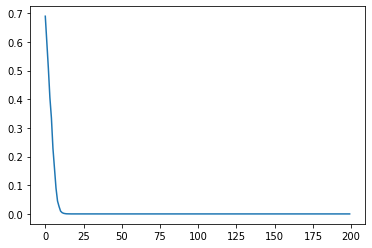

In [320]:
#training encoder
losses = []
epoches = 100
model.train_encoder(True)
for epoch in range(epochs):
  optimizer.zero_grad()
  x = torch.tensor(np.random.randint(0, 2, (100, 2)), dtype = torch.float32)
  pred = model(x)
  loss = criterion(pred, x)
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
plt.plot(np.arange(len(losses)), losses)

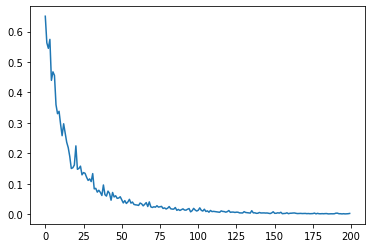

In [321]:
#training decoder with AWGN
lr = 5e-6
epochs = 200
batch_size = 50
model.train_encoder(False)
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.BCELoss()
losses = []
for epoch in range(epochs):
  batch_loss = []
  for batch in range(batch_size):
    optimizer.zero_grad()
    x = torch.tensor(np.random.randint(0, 2, (101, 2)), dtype = torch.float32)
    pred = model(x)
    loss = criterion(pred, x)
    batch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  losses.append(sum(batch_loss)/len(batch_loss))
plt.plot(np.arange(len(losses)), losses)

In [322]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


In [328]:
target_dir = '/content/drive/MyDrive/Antenna/project/'
# del input
i = input()
torch.save(model, target_dir + 'weights/model/' + '1' + '.pt')
torch.save(model, target_dir + 'weights/optimizer/' + '1' + '.pt')

1


In [ ]:
plt.plot(range(epochs), losses)

In [314]:
model2 = Network()
# print(model2)
x = torch.tensor(np.random.randint(0, 2, (101, 2)), dtype = torch.float32)
# print(model2(x))


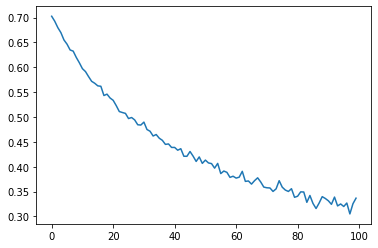

In [315]:
model2.train_encoder(False)
lr = 5e-6
epochs = 100
batch_size = 50
optimizer = optim.Adam(model2.parameters(), lr = lr)
criterion = nn.BCELoss()
losses = []
for epoch in range(epochs):
  batch_loss = []
  for batch in range(batch_size):
    optimizer.zero_grad()
    x = torch.tensor(np.random.randint(0, 2, (101, 2)), dtype = torch.float32)
    pred = model2(x)
    loss = criterion(pred, x)
    batch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  losses.append(sum(batch_loss)/len(batch_loss))
plt.plot(np.arange(len(losses)), losses)

In [57]:
      model = Network()
x = torch.tensor([np.arange(4)], dtype = torch.float32)
x = torch.reshape(x, (2,2))
y = x.detach().clone()
# x = model.forward(x)
print(x)
# params = list(model.parameters())
# print(params)
out = model(x)
# print(y)
# print(out)
criterion = nn.CrossEntropyLoss()
y = torch.tensor([1, 0], dtype=torch.long)
loss = criterion(out, y)
print(out)
print(loss)

tensor([[0., 1.],
        [2., 3.]])
tensor([[0.5057, 0.4943],
        [0.5236, 0.4764]], grad_fn=<SoftmaxBackward>)
tensor(0.6844, grad_fn=<NllLossBackward>)


In [105]:
model = Network()
x = torch.tensor(np.random.randint(0, 2, (100, 2)), dtype = torch.float32)
print(x.shape)
y = x.detach().clone()
pred = model(x)
criterion = nn.BCELoss()
loss = criterion(pred, y)
print(loss)



torch.Size([100, 2])
tensor(0.6941, grad_fn=<BinaryCrossEntropyBackward>)


In [109]:
epochs = 1000
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr = lr)
losses = []
for epoch in range(epochs):
  x = torch.tensor(np.random.randint(0, 2, (100, 2)), dtype = torch.float32)
  optimizer.zero_grad()
  pred = model(x)
  loss = criterion(pred, x)
  losses.append(loss.item())
  # print(loss)
  loss.backward()
  optimizer.step()

In [108]:
lt = 2
ct = 0
for child in model.children():
  if(ct >= 2):
    break
  ct += 1
  for param in child.parameters():
    param.requires_grad=False

In [306]:
for child in model.children():
  print(child)

Linear(in_features=2, out_features=500, bias=True)
Linear(in_features=500, out_features=200, bias=True)
Linear(in_features=200, out_features=400, bias=True)
Linear(in_features=400, out_features=500, bias=True)
Linear(in_features=500, out_features=2, bias=True)
Sigmoid()
Softmax(dim=1)


[0.00228555197827518, 0.0022857508156448603, 0.002244663657620549, 0.002108772750943899, 0.002128125401213765, 0.0020298599265515804, 0.0020638981368392706, 0.001978337299078703, 0.001946647884324193, 0.0019035609439015388, 0.0018988741794601083, 0.0018688846612349153, 0.0018069170182570815, 0.0017493698978796601, 0.0017318736063316464, 0.0016475218581035733, 0.0016373059479519725, 0.0016450727125629783, 0.0016174735501408577, 0.0015358623350039124, 0.0015294679906219244, 0.0015058373101055622, 0.0014514120994135737, 0.0014397086342796683, 0.0014143711887300014, 0.0013956902548670769, 0.0013529413845390081, 0.0013389548985287547, 0.0012898180866613984, 0.0013009031536057591, 0.0012689747381955385, 0.0012553827837109566, 0.0012169426772743464, 0.0012065251357853413, 0.0011983034200966358, 0.0011802008375525475, 0.0011557858670130372, 0.0011042312253266573, 0.0010973402531817555, 0.0010698094265535474, 0.0010584155097603798, 0.001048126257956028, 0.001038185553625226, 0.00098437292035669

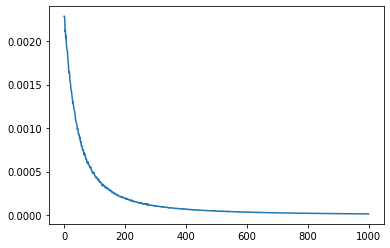

In [110]:
print(losses)
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)), losses)

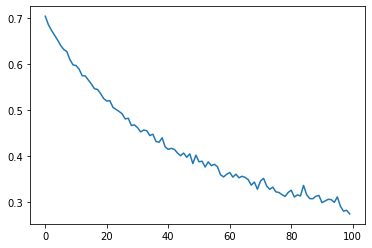

In [273]:
lr = 5e-6
epochs = 100
batch_size = 50
optimizer = optim.Adam(model2.parameters(), lr = lr)
criterion = nn.BCELoss()
losses = []
for epoch in range(epochs):
  batch_loss = []
  for batch in range(batch_size):
    optimizer.zero_grad()
    x = torch.tensor(np.random.randint(0, 2, (101, 2)), dtype = torch.float32)
    pred = model2(x)
    loss = criterion(pred, x)
    batch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  losses.append(sum(batch_loss)/len(batch_loss))
plt.plot(np.arange(len(losses)), losses)

In [91]:
model2 = Network()
model2.load_state_dict(model.state_dict())
print(model2.parameters())

TypeError: ignored

In [62]:
predicted = torch.tensor([[1,10,3,4]]).float()
print(predicted.shape)
target = torch.tensor([1]).long()
lossfxn = nn.CrossEntropyLoss()
print(target.shape)
loss = lossfxn(predicted, target)
print(loss)

torch.Size([1, 4])
torch.Size([1])
tensor(0.0035)


In [ ]:
rom scipy.stats import unitary_group
Nt = 3
Nr = 4
U = unitary_group.rvs(Nt)
V = unitary_group.rvs(Nr)
print(U)

In [ ]:
import random
import math
import numpy as np
import cmath

In [ ]:
random.seed(10)
diag = []
for i in range(min(Nt, Nr)):
  phi = random.random()*math.pi*2
  diag.append(cmath.rect(1, phi))
  print(diag[-1])
sigma = np.zeros((Nt, Nr), complex)
np.fill_diagonal(sigma, diag)
print(sigma)

(-0.901039672957227-0.433736680207166j)
(-0.9018329764934756+0.43208480939384847j)
(-0.8820210563400136-0.4712099915885132j)
[[-0.90103967-0.43373668j  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.90183298+0.43208481j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.88202106-0.47120999j
   0.        +0.j        ]]


In [ ]:
H = np.matmul(U, sigma)
H = np.matmul(H, np.conj(V))
print(H)
print('H shape: ', H.shape)

[[-0.2476991 +0.45580005j  0.34135201-0.5071371j  -0.43460317+0.13126867j
  -0.29015205+0.25861678j]
 [-0.44513694+0.17186702j -0.3518476 -0.15068592j  0.04703815-0.61046586j
   0.40969914+0.28823135j]
 [-0.63917872+0.1365047j  -0.33212015+0.38405347j  0.08289833+0.53453516j
  -0.14204106+0.04733433j]]
H shape:  (3, 4)


In [ ]:
var = 1
n = np.random.normal(0, var, (Nr, 2)).view(np.complex128)
print(n)

[[ 1.10659975-0.37812048j]
 [-0.16889935+1.34367067j]
 [-1.45615713-0.00492412j]
 [-0.04872485-1.3344347j ]]


In [ ]:
a = torch.tensor([1.0+ 5j, 2.0], dtype=torch.complex64)
print(a)

tensor([1.+5.j, 2.+0.j])


In [ ]:
a = torch.tensor([[1 + 5j, 2 + 6j]], dtype=torch.complex64)
b = torch.tensor([[2 + 3j], [4 + -1j]], dtype=torch.complex64)
print(a)
print(b)
c = a.matmul(b)
print(c)
print(a)
print(b)

tensor([[1.+5.j, 2.+6.j]])
tensor([[2.+3.j],
        [4.-1.j]])
tensor([[1.+35.j]])
tensor([[1.+5.j, 2.+6.j]])
tensor([[2.+3.j],
        [4.-1.j]])


In [ ]:
print(a.shape[0])

1


In [ ]:
t = torch.reshape(a, (2, 1))
print(a)
print(t)

tensor([[1.+5.j, 2.+6.j]])
tensor([[1.+5.j],
        [2.+6.j]])


In [ ]:
!pip install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.1+cu101)


In [ ]:
print(torch.__version__)

1.7.0+cu101


In [55]:
inp = torch.ones(3, 5, requires_grad=True)
print(inp)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)
tensor([2, 0, 4])


In [113]:
x = torch.tensor([1, 2], dtype = torch.float32, requires_grad=False)

In [114]:
print(x)

tensor([1., 2.])
